PC

## -*- coding: utf-8 -*-
# """PC_VERY_Simple_PytorchOptimization_6.ipynb

## Import

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset

import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
from PC_Parameters import default_parameters_network

pars = default_parameters_network()


{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[-5.53087287e-05],
       [ 8.12621598e-04],
       [-4.05608567e-04],
       [ 6.76161863e-05]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


## Functions
### Basics ones

In [3]:
#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead

*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation


def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)


"""### Try Normalization to "make it proba"
"""


def make_it_proba(r_e):
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) this pose problem
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)


"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0))
    return dirac_1d




## Class

### 1- Basic classes

In [4]:


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    # I1, I2 = pars['I1'], pars['I2']
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°
class Neurons:
    def __init__(neur, Ltime, Ntime, RFfrequency=0, init_r=0, init_S=0):
        neur.r = torch.zeros((Ltime, Ntime), dtype=torch.float32, requires_grad=False)
        neur.drdt = torch.zeros((Ltime, Ntime), dtype=torch.float32, requires_grad=False)
        neur.S = torch.zeros((Ltime, Ntime), dtype=torch.float32, requires_grad=False)
        neur.Itot = torch.zeros((Ltime, Ntime), dtype=torch.float32, requires_grad=False)  # , requires_grad = False
        neur.Phi = torch.zeros((Ltime, Ntime), dtype=torch.float32, requires_grad=False)  # np.zeros(Ltime)
        neur.rinit = init_r
        neur.Sinit = init_S
        neur.RFf = RFfrequency
        if neur.Sinit != 0:
            neur.S[0, :] = neur.Sinit
        # neur.S = np.full((Ltime, Ntime), neur.Sinit)

    def printNeur(neur):
        print("size S and r andItot and Phi is: ", neur.S.shape, neur.r.shape, neur.Itot.shape, neur.Phi.shape)


class Stim:
    def __init__(self, param, simu, f, ISI=1, dur=0.2):  # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        # print(f.shape)
        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)


### 2- Model Classes

In [12]:

class MyModel(nn.Module): #nn.Sequential
    def __init__(self, param, sim, Jall): #,**kwargs): ## Chang !! only input in init is self, N is the only parameter
        super(MyModel, self).__init__()
        # Define other model parameters, layers, or components here if needed
        self.param = param
        self.dt = sim.dt #hardcode here as well
        self.N = (param.N) #hardcode here as well
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad = True))#just the number here )Jall[0])
        self.Jei = nn.Parameter(Jall[1])
        self.Jie = nn.Parameter(Jall[2])
        self.Jii = nn.Parameter(Jall[3])
        self.Jin = nn.Parameter(Jall[4])

        # remove phi
    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        """neg_mulA_I = torch.neg(torch.multiply(a, I_tot))
        exp_b = torch.exp(torch.add(neg_mulA_I, b))
        divide_and_one = torch.divide(1, torch.add(exp_b, 1))
        mul_hm = torch.mul(hm, divide_and_one) #mul_hm"""
        return torch.multiply(hm, torch.divide(1, (1 + torch.exp(- (torch.multiply(a, I_tot) + b)))))  #torch.multiply(hm, torch.divide(torch.ones(1), (torch.add(torch.ones(1), torch.exp(torch.add(torch.neg(torch.multiply(a, I_tot)), b)))
            

    def forward(self, In):
        #In = stim
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)  
        r_i = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        s_ampa = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)#.detach()
        s_gaba = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        i_tot_e = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        i_tot_i = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        dr_e_dt = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        dr_i_dt = torch.zeros((In.shape[0], self.N), requires_grad=False, dtype=torch.float32)
        
        # Perform integration over time steps 
        # Not storing all the time step!
        for k in range(1, In.shape[0]):
            s_gaba_wie = s_gaba[k - 1, :] @ self.param.wie  # replaced torch.matmul() by @
            s_ampa_wei = s_ampa[k - 1, :] @ self.param.wei  # @ is an inplace operation!
            s_gaba_wii = s_gaba[k - 1, :] @ (self.param.wii)
            
            # ic(Sampa_Jee.grad_fn)
            ##make Jee *r depend on r # 
            i_tot_e[k, :] = self.Jee * s_ampa[k - 1, :] - (self.Jie * s_gaba_wie) + self.Jin * In[k - 1, :]
            i_tot_i[k, :] = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)


            phi_arr_e = self.phi(i_tot_e[k, :], self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :], self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :] = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue#Jee*r remove pi and S
            dr_i_dt[k, :] = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :] * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :] * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        return softmax(r_e), softmax(r_i) #softmax softmax  




In [13]:
"""
self.Jee = nn.Parameter((torch.tensor((self.dicJ['Jee']), requires_grad=True, dtype=torch.float32)))
self.Jei = nn.Parameter((torch.tensor((self.dicJ['Jei']), requires_grad=True, dtype=torch.float32)))
self.Jie = nn.Parameter((torch.tensor((self.dicJ['Jie']), requires_grad=True, dtype=torch.float32)))
self.Jii = nn.Parameter((torch.tensor((self.dicJ['Jii']), requires_grad=True, dtype=torch.float32)))
self.Jin = nn.Parameter((torch.tensor((self.dicJ['Jin']), requires_grad=True, dtype=torch.float32)))
"""

"""
#sgaba = s_gaba.detach().clone()
#s_gaba_wie = s_gaba[k - 1, :] @ self.param.wie  # replaced torch.matmul() by @
s_gaba_wie = torch.matmul(s_gaba[k - 1, :], self.param.wie)
#sampa = s_ampa.detach().clone()
#s_ampa_wei = s_ampa[k - 1, :] @ self.param.wei
s_ampa_wei = torch.matmul(s_ampa[k - 1, :], self.param.wei) # @ is an inplace operation!
#s_gaba_wii = s_gaba[k - 1, :] @ (self.param.wii)
s_gaba_wii = torch.matmul(s_gaba[k - 1, :], self.param.wii)
#s_ampa = s_ampa.detach().clone()
sampa = s_ampa[k - 1, :]# .detach().clone()
Sampa_Jee = torch.mul(self.Jee, sampa)
Sgaba_Jie = torch.mul(self.Jie, s_gaba_wie)
In_Jin = torch.mul(self.Jin, In[k - 1, :])# self.Jin * In[k - 1, :] # mul for scalar
Sampa_Jei = torch.mul(self.Jei, s_ampa_wei) #self.Jee * s_ampa_wei#torch.matmul() # self.Jee.clone() destroys the gradient
# ic(Sampa_Jee.grad_fn)
i_tot_e[k, :] = Sampa_Jee - Sgaba_Jie + In_Jin
i_tot_i[k, :] = Sampa_Jei - torch.mul(self.Jii, s_gaba_wii)"""

#i_tot_e[k, :] = (self.Jee * s_ampa[k-1,:]) - (self.Jie * s_gaba_wie) + (self.Jin * In[k - 1, :])
#i_tot_i[k, :] = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

#Phi
# return hm * (1 / (1 + torch.exp(- (a * I_tot + b))))

'\n#sgaba = s_gaba.detach().clone()\n#s_gaba_wie = s_gaba[k - 1, :] @ self.param.wie  # replaced torch.matmul() by @\ns_gaba_wie = torch.matmul(s_gaba[k - 1, :], self.param.wie)\n#sampa = s_ampa.detach().clone()\n#s_ampa_wei = s_ampa[k - 1, :] @ self.param.wei\ns_ampa_wei = torch.matmul(s_ampa[k - 1, :], self.param.wei) # @ is an inplace operation!\n#s_gaba_wii = s_gaba[k - 1, :] @ (self.param.wii)\ns_gaba_wii = torch.matmul(s_gaba[k - 1, :], self.param.wii)\n#s_ampa = s_ampa.detach().clone()\nsampa = s_ampa[k - 1, :]# .detach().clone()\nSampa_Jee = torch.mul(self.Jee, sampa)\nSgaba_Jie = torch.mul(self.Jie, s_gaba_wie)\nIn_Jin = torch.mul(self.Jin, In[k - 1, :])# self.Jin * In[k - 1, :] # mul for scalar\nSampa_Jei = torch.mul(self.Jei, s_ampa_wei) #self.Jee * s_ampa_wei#torch.matmul() # self.Jee.clone() destroys the gradient\n# ic(Sampa_Jee.grad_fn)\ni_tot_e[k, :] = Sampa_Jee - Sgaba_Jie + In_Jin\ni_tot_i[k, :] = Sampa_Jei - torch.mul(self.Jii, s_gaba_wii)'

## Call the model and the classes


In [14]:

N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
sigmas = [param.sOut, param.sEI]  # = sigmas
print("sIN", sigmas[0] / 30, "sout", sigmas[0], "sEI", sigmas[1])
print("Jee:", param.Jee, "  Jei:", param.Jei)
print("Jii", param.Jii, "Jie:", param.Jie, " Jin:", param.Jin)
J = param.Jin, param.Jee, param.Jie, param.Jei, param.Jii

# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4)  # dt #rangeSim #dur = 2s
simu.printSim()

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.3, f=[8], ISI=.05)  # dur = 1s Isi=1s
In, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.)


# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
Jee = torch.tensor((J1['Jee']), requires_grad=True, dtype=torch.float32)
Jei = ((torch.tensor((J1['Jei']), requires_grad=True, dtype=torch.float32)))
Jie = ((torch.tensor((J1['Jie']), requires_grad=True, dtype=torch.float32)))
Jii = ((torch.tensor((J1['Jii']), requires_grad=True, dtype=torch.float32)))
Jin = ((torch.tensor((J1['Jin']), requires_grad=True, dtype=torch.float32)))

Jall = [Jee,Jei,Jie,Jii,Jin]       
mymodel = MyModel(param, simu, Jall)#**J1)  # these ** pass J as an unpacked dict, not as a single positional argument



sIN 0.1 sout 3.0 sEI 0.2
Jee: 0.2   Jei: 1.4
Jii 6.7 Jie: 0.2  Jin: 0.008
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


In [15]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32) #).float()
#r_e, r_i = mymodel.forward(stim=sti)  # ,r_i, dr_e_dt, dr_i_dt, s_ampa, s_gaba, i_tot_e, i_tot_i, In,

#HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)


## Optimization steps

### Parameters Initialization

In [16]:

# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
learning_rate = 0.001 #0.00001 #0,001
optimizer = optim.SGD(mymodel.parameters(),
                      lr=learning_rate) 

# +++++++++++++++++++++++++ Epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
num_epochs = 2

# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}  #J_tensor = torch.tensor([0.072, 0.004, 0.05, 0.6, 0.00695])
J_list = list(J1.keys())

X_input = sti.requires_grad_(False)  # .requires_grad_(True)
Y_target = get_expected_Y_relu(X_input)  # .requires_grad_(False)
losses = torch.zeros(num_epochs)

#Y_prediction, r_i = mymodel.forward(stim=sti)
#HeatMap(X_input.detach().numpy(), r_i.detach().numpy(), J1)
#HeatMap(Y_prediction.detach().numpy(), r_i.detach().numpy(), J1)

### Optimization steps

In [18]:
# +++++++++++++++++++++++++ Problems investigations +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# import tracemalloc
# tracemalloc.start()

"""

def zero_grad2(params):
    """
  Clear gradients as they accumulate on successive backward calls
  Args:
    params: an iterator over tensors
  """
    for par in params:
        if not (par.grad is None):
            par.grad.data.zero_()"""



# +++++++++++++++++++++++++ Optimization loop +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

with torch.autograd.set_detect_anomaly(True):
    for epoch in range(num_epochs):
        
        
        # Clear the gradients and zero_grad the optimizer
        optimizer.zero_grad()
        
        # calculate output
        Y_prediction, I = mymodel(X_input) 

        # calculate loss
        loss = torch.sum(torch.mean((Y_prediction - Y_target)**2, axis=1))  
        #ic(loss.grad_fn)
        
        loss.backward()#retain_graph=True


        optimizer.step()

        #losses[epoch] = loss
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}, Loss_grad: {loss.grad_fn}')  # .item()
        #ic((mymodel.parameters()))
        for i, par in enumerate(mymodel.parameters()):
            ic(J_list[i], par, par.grad)
        



c:\Users\knzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\knzga\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\knzga\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "C:\Users\knzga\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start
    self.io_loop.start()
  File "C:\Users\knzga\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\knzga\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in ru

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20]], which is output 0 of AsStridedBackward0, is at version 3998; expected version 3997 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

### Model evaluation

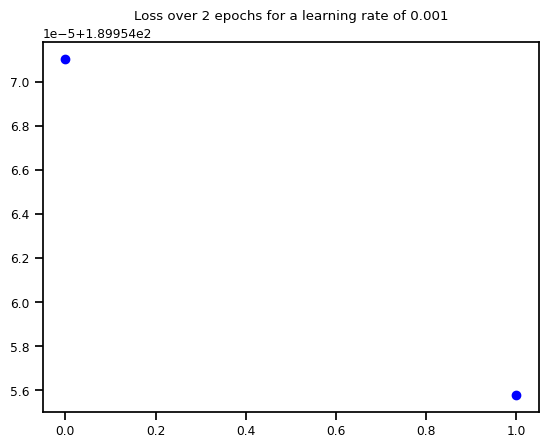

In [ ]:

## +++++++++++++++++++++++++ Loss over time +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {learning_rate}")
plt.show()